Contato: ciro@mail.org

# Visão geral do problema e do QAOA



## 1. Otimização de portfólio

A tarefa de otimizar um portfólio pode ser formulada como maximizar retornos (ou minimizar custos equivalentes) sob certas restrições, como:

Limite no número de ativos que podemos escolher (budget).
Limite de investimentos simultâneos (max_investments).
Penalizar a correlação (risco) entre os ativos (quanto maior a correlação entre dois ativos que escolhemos simultaneamente, maior o risco).
Em termos matemáticos, podemos representar essa tarefa por meio de uma função objetivo que deve ser minimizada ou maximizada e restrições lineares/inteiras (e.g., número máximo de ativos). Quando falamos de QAOA, transformamos esse problema em um modelo quadrático binário (Quadratic Program), em que cada ativo pode ser selecionado (x_i = 1) ou não (x_i = 0).

## 2. QAOA (Quantum Approximate Optimization Algorithm)

O QAOA é um algoritmo quântico variacional projetado para resolver problemas de otimização combinatória. De forma simplificada:

### **2.1 Cost Hamiltonian (Hc)**: representa a função objetivo que desejamos minimizar. No problema de portfólio, é construída a partir do “retorno” (com sinal negativo para minimizar custos e maximizar lucros) e das correlações (que adicionam termos quadráticos).

### **2.2 Mixer Hamiltonian (Hm)**: responsável por “explorar” os possíveis estados no espaço de busca. Usualmente, ele é definido como a soma de operadores X (rotação em torno do eixo X) em cada qubit, incentivando transições entre
∣0⟩ e ∣1⟩.

### **2.3 Camadas QAOA**: para um número p de repetições, aplica-se alternadamente a evolução unidimensional pelo Cost Hamiltonian e depois pelo Mixer Hamiltonian. As durações desses blocos (ou ângulos de rotação) são parâmetros variacionais (γ e β) que o algoritmo (geralmente um otimizador clássico) vai ajustando.

## 3. Interpretação do resultado

No final, medimos o estado quântico resultante e, a partir das distribuições de 0s e 1s nos qubits, encontramos a solução do problema. Em Qiskit, o MinimumEigenOptimizer utiliza a saída de um “minimum eigen solver” (no caso, o QAOA) para determinar a melhor atribuição binária para as variáveis.

# Resolvendo Classicamente

- Utiliza métodos determinísticos (ou heurísticos).

- Depende de simplificações para tornar o problema resolvível em tempo prático.

- Pode ser menos eficiente para grandes problemas quadráticos, mas é direto e amplamente aplicável.

In [1]:
import numpy as np
from scipy.optimize import linprog

def optimize_portfolio_classical(returns, correlations, budget, max_investments):
    """
    Otimiza um portfólio de investimentos usando métodos clássicos.

    Parâmetros:
        returns (dict): Retornos esperados das ações, e.g., {'A': 0.4, 'B': 0.55, 'C': 0.45}.
        correlations (dict): Correlações entre pares de ações, e.g., {('B', 'C'): 0.2}.
        budget (int): Número máximo de ações que podem ser escolhidas.
        max_investments (int): Número máximo de investimentos simultâneos permitidos.

    Retorna:
        dict: Decisões de investimento otimizadas.
    """
    stocks = list(returns.keys())
    n = len(stocks)

    # Função objetivo: minimizar -retornos + penalização por correlação
    c = np.zeros(n)
    for i, stock in enumerate(stocks):
        c[i] = -returns[stock]  # Minimizar -retornos (maximizar retornos)

    # Matriz de penalização de correlações
    Q = np.zeros((n, n))
    for (stock1, stock2), correlation in correlations.items():
        i, j = stocks.index(stock1), stocks.index(stock2)
        Q[i, j] = correlation
        Q[j, i] = correlation  # Simétrica

    # Linearizar o problema quadrático: f(x) = c @ x + x.T @ Q @ x
    # Expandir para incluir a parte quadrática
    c += Q.sum(axis=1)

    # Restrições
    # 1. Orçamento (número total de ações <= budget)
    A = np.ones((1, n))
    b = [budget]

    # 2. Máximo de investimentos simultâneos (soma dos escolhidos <= max_investments)
    A = np.vstack([A, np.ones((1, n))])
    b.append(max_investments)

    # Limites binários (0 ou 1)
    bounds = [(0, 1) for _ in range(n)]

    # Resolver o problema
    result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")

    # Converter resultados
    if result.success:
        decision = {stocks[i]: int(round(x)) for i, x in enumerate(result.x)}
        return decision
    else:
        raise ValueError("Problema não foi resolvido com sucesso.")

In [2]:
# Exemplo de uso

# Parâmetros do problema
returns = {'A': 0.4, 'B': 0.55, 'C': 0.45, 'D': 0.6}  # retorno da ação: A = 40%
correlations = {('B', 'C'): 0.2, ('A', 'D'): 0.3}
budget = 3  # orçamento (quantidade máxima de ações a serem escolhidas)
max_investments = 3  # máximo de investimentos simultâneos

# Resolver o problema
solution = optimize_portfolio_classical(returns, correlations, budget, max_investments)

# Exibir o resultado
print("Solução encontrada:", solution)

Solução encontrada: {'A': 0, 'B': 1, 'C': 1, 'D': 1}


# Solução com Computação Quântica

- Explora o espaço de soluções utilizando propriedades de sobreposição e entrelaçamento.

- Pode ser útil para problemas altamente complexos e não convexos.

## Instalando as dependências necessárias

In [3]:
!pip install -q qiskit==0.36.0 qiskit_optimization==0.3.1 pylatexenc

## Visualizando o Problema

     ┌─────────┐┌─────────────┐┌─────────────┐┌─────────────┐┌─────────────┐»
q_0: ┤ U2(0,π) ├┤0            ├┤0            ├┤0            ├┤0            ├»
     ├─────────┤│  exp(it IZ) ││  exp(it ZI) ││  exp(it ZZ) ││  exp(it XI) │»
q_1: ┤ U2(0,π) ├┤1            ├┤1            ├┤1            ├┤1            ├»
     └─────────┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘»
«     ┌─────────────┐
«q_0: ┤0            ├
«     │  exp(it IX) │
«q_1: ┤1            ├
«     └─────────────┘


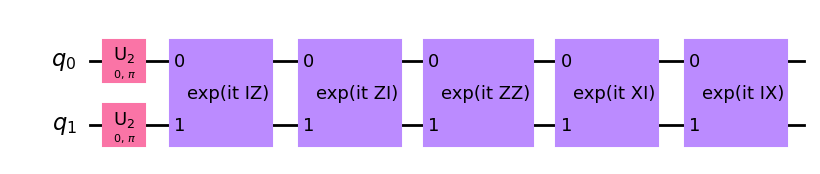

In [4]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import to_ising
from qiskit.algorithms import QAOA
from qiskit import Aer
import numpy as np

# 1) QuadraticProgram de exemplo
qp = QuadraticProgram()

# Duas variáveis binárias: x0, x1
x0 = qp.binary_var(name='x0')
x1 = qp.binary_var(name='x1')

# Exemplo de função objetivo: minimize -(x0 + 2*x1) + 1.5*x0*x1
#    --> Equivalente a maximizar (x0 + 2*x1) - penalizar 1.5 se ambos forem 1
qp.minimize(linear={'x0': -1, 'x1': -2},
            quadratic={('x0', 'x1'): 1.5})

# Adiciona uma restrição simples, por exemplo x0 + x1 <= 1
qp.linear_constraint({'x0': 1, 'x1': 1}, '<=', 1, 'budget_constraint')

qubo_problem = QuadraticProgramToQubo().convert(qp) # O QAOA espera um PauliSumOp (ou algum objeto OperatorBase) que descreva o Hamiltoniano do problema

# Converte QUBO em Ising Operator
op, offset = to_ising(qubo_problem)

# Instancia o simulador de backend
backend = Aer.get_backend('aer_simulator')

# Uma única aplicação do Cost Hamiltonian e uma do Mixer Hamiltonian
qaoa = QAOA(reps=1, quantum_instance=backend)

initial_params = [0.5, 0.8]  # (gamma, beta) p=1 => 2 parâmetros
qaoa_circ = qaoa.construct_circuit(parameter=initial_params, operator=op)

my_circuit = qaoa_circ[0].decompose()  # para "abrir" as subrotinas
print(my_circuit.draw(output='text'))  # ASCII
my_circuit.draw(output='mpl')


- As linhas q_0 e q_1 representam dois qubits (duas “partículas quânticas” ou duas “posições de bit quântico”)

- Cada bloco desse circuito realiza uma transformação nesses qubits, podendo criar superposição (para explorar várias possibilidades ao mesmo tempo) ou introduzir correlações/entanglement (para “ligar” o comportamento entre os qubits)

- A notação exp(i t XYZ...) é a forma “exponencial” de dizer que estamos girando (fazendo rotações) em torno de algum eixo (X, Y ou Z) ou envolvendo mais de um qubit (como ZZ)

- A porta U2(0, π) que aparece no Qiskit é, na prática, equivalente à porta Hadamard (H)

- Colocar um Hadamard em cada qubit (q_0 e q_1) faz com que cada um esteja em “superposição” (metade do tempo é 0, metade do tempo é 1). Isso permite que o circuito explore vários estados ao mesmo tempo

Em poucas palavras, o circuito está:

(1) Criando superposição,
(2) Ajustando fases e criando correlações (para refletir o problema que se quer resolver),
(3) Fazendo rotações que trocam estados, possibilitando que o sistema se “redistribua” até acharmos (via medições e ajustes de parâmetros) a melhor configuração de 0s e 1s.

## Adaptando o problema para um simulador quântico

In [5]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from qiskit import Aer

def optimize_portfolio(returns, correlations, budget, max_investments):
    """
    Otimiza um portfólio de investimentos usando QAOA.

    Parâmetros:
        returns (dict): Retornos esperados das ações, e.g., {'A': 0.4, 'B': 0.55, 'C': 0.45}.
        correlations (dict): Correlações entre pares de ações, e.g., {('B', 'C'): 0.2}.
        budget (int): Número máximo de ações que podem ser escolhidas.
        max_investments (int): Número máximo de investimentos simultâneos permitidos.

    Retorna:
        dict: Decisões de investimento otimizadas.
    """
    # Criação do problema de otimização
    qp = QuadraticProgram()

    # Definir variáveis binárias para cada ativo
    variables = {}
    for stock in returns:
        variables[stock] = qp.binary_var(name=f"x_{stock}")

    # Definir a função objetivo (minimizar o custo -maximizar retorno- com penalização de risco)
    qp.minimize(linear={f"x_{k}": -v for k, v in returns.items()}, quadratic={(f"x_{k1}", f"x_{k2}"): v for (k1, k2), v in correlations.items()})

    # Adicionar restrições
    # Restrição de orçamento (quantidade máxima de ações a serem escolhidas)
    qp.linear_constraint({f"x_{k}": 1 for k in returns}, "<=", budget, "budget_constraint")

    # Restrição de máximo de investimentos simultâneos
    qp.linear_constraint({f"x_{k}": 1 for k in returns}, "<=", max_investments, "max_investments_constraint")

    # Configurar o simulador quântico
    backend = Aer.get_backend('aer_simulator')

    # Configurar o QAOA com um callback para monitorar o progresso
    def qaoa_callback(eval_count, parameters, mean, std):
        print(f"[QAOA] Iteração {eval_count}: Parâmetros: {parameters}, Média: {mean}, Desvio: {std}")

    # Configurar o QAOA
    qaoa = QAOA(reps=1, quantum_instance=backend)
    #qaoa = QAOA(reps=1, quantum_instance=backend, callback=qaoa_callback)
    optimizer = MinimumEigenOptimizer(qaoa)

    # Resolver o problema
    result = optimizer.solve(qp)

    # Retornar as decisões de investimento
    return result.variables_dict


In [6]:
# Exemplo de uso

# Parâmetros do problema
returns = {'A': 0.4, 'B': 0.55, 'C': 0.45, 'D': 0.6}  # retorno da ação: A = 40%
correlations = {('B', 'C'): 0.2, ('A', 'D'): 0.3}
budget = 3 # orçamento (quantidade máxima de ações a serem escolhidas)
max_investments = 3 # máximo de investimentos simultâneos

# Resolver o problema
solution = optimize_portfolio(returns, correlations, budget, max_investments)

# Exibir o resultado
print("Solução encontrada:", solution)

Solução encontrada: {'x_A': 0.0, 'x_B': 1.0, 'x_C': 1.0, 'x_D': 1.0}


## Adaptando ao Problema da Loteria

### 1. Transformação do Problema

- Em vez de ações, usamos números do sorteio como variáveis.

- Os retornos esperados são representados pela frequência ou probabilidade de cada número ser sorteado com base no histórico.

- As correlações podem representar a frequência com que dois números aparecem juntos nos sorteios anteriores.

### 2. Função Objetivo

- Maximizar a probabilidade de acerto com base na frequência dos números escolhidos, minimizando a redundância (ou seja, não escolher muitos números com alta correlação).

### 3. Restrições

- Escolher um número fixo de opções (por exemplo, 6 números para uma loteria).

- Garantir a diversidade nos números escolhidos, evitando combinações altamente correlacionadas.

## Importando os Dados

O dataset "Mega-Sena.xlsx" pode ser importado de:

https://loterias.caixa.gov.br/Paginas/Mega-Sena.aspx

ao final da página.

Faça o upload para o ambiente do Colab.


In [3]:
import pandas as pd

df_mega_sena = pd.read_excel('Mega-Sena.xlsx')
df_mega_sena.head()

,Concurso,Data do Sorteio,Bola1,Bola2,Bola3,Bola4,Bola5,Bola6,Ganhadores 6 acertos,Cidade / UF,Rateio 6 acertos,Ganhadores 5 acertos,Rateio 5 acertos,Ganhadores 4 acertos,Rateio 4 acertos,Acumulado 6 acertos,Arrecadação Total,Estimativa prêmio,Acumulado Sorteio Especial Mega da Virada,Observação
0,1,11/03/1996,4,5,30,33,41,52,0,NaN,"R$0,00",17,"R$39.158,92",2016,"R$330,21","R$1.714.650,23","R$0,00","R$0,00","R$0,00",NaN
1,2,18/03/1996,9,37,39,41,43,49,1,PR,"R$2.307.162,23",65,"R$14.424,02",4488,"R$208,91","R$0,00","R$0,00","R$0,00","R$0,00",NaN
2,3,25/03/1996,10,11,29,30,36,47,2,RN; SP,"R$391.192,51",62,"R$10.515,93",4261,"R$153,01","R$0,00","R$0,00","R$0,00","R$0,00",NaN
3,4,01/04/1996,1,5,6,27,42,59,0,NaN,"R$0,00",39,"R$15.322,24",3311,"R$180,48","R$717.080,75","R$0,00","R$0,00","R$0,00",NaN
4,5,08/04/1996,1,2,6,16,19,46,0,NaN,"R$0,00",98,"R$5.318,10",5399,"R$96,53","R$1.342.488,85","R$0,00","R$0,00","R$0,00",NaN


In [4]:
df_mega_sena = df_mega_sena[['Concurso', 'Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']]
df_mega_sena.head()

,Concurso,Bola1,Bola2,Bola3,Bola4,Bola5,Bola6
0,1,4,5,30,33,41,52
1,2,9,37,39,41,43,49
2,3,10,11,29,30,36,47
3,4,1,5,6,27,42,59
4,5,1,2,6,16,19,46


## Implementando o algoritmo

In [9]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from qiskit import Aer
import pandas as pd
import itertools

def calculate_frequencies_and_correlations(df):
    """
    Calcula as frequências e correlações de números de loteria a partir de um dataframe.

    Parâmetros:
        df (pd.DataFrame): Dataframe contendo os resultados dos concursos.

    Retorna:
        tuple: (frequências, correlações), ambos como dicionários.
    """
    # Lista de todas as bolas sorteadas em todos os concursos
    all_numbers = df.iloc[:, 1:].values.flatten()

    # Frequências: contagem de cada número
    frequencies = pd.Series(all_numbers).value_counts(normalize=True).to_dict()

    # Correlações: frequência de pares de números
    num_contests = len(df)
    pairs = itertools.combinations(range(1, 61), 2)  # Pares de números possíveis (1 a 60)
    correlations = {}

    for pair in pairs:
        # Contar concursos onde ambos os números aparecem
        count = df.apply(lambda row: pair[0] in row.values and pair[1] in row.values, axis=1).sum()
        correlations[pair] = count / num_contests  # Frequência conjunta normalizada

    return frequencies, correlations

def optimize_lottery(numbers_frequency, numbers_correlation, picks):
    """
    Otimiza a escolha de números para um sorteio baseado em um histórico de resultados.

    Parâmetros:
        numbers_frequency (dict): Frequência de cada número no histórico, e.g., {1: 0.1, 2: 0.2, ..., 60: 0.05}.
        numbers_correlation (dict): Correlações entre números, e.g., {(1, 2): 0.05, (3, 4): 0.03}.
        picks (int): Quantidade de números a escolher.

    Retorna:
        dict: Números sugeridos para o sorteio.
    """
    # Criação do problema de otimização
    qp = QuadraticProgram()

    # Definir variáveis binárias para cada número
    variables = {}
    for number in numbers_frequency:
        variables[number] = qp.binary_var(name=f"x_{number}")

    # Definir a função objetivo (maximizar a frequência e penalizar correlações altas)
    qp.maximize(
        linear={f"x_{k}": v for k, v in numbers_frequency.items()},
        quadratic={(f"x_{k1}", f"x_{k2}"): -v for (k1, k2), v in numbers_correlation.items()},
    )

    # Restrição de quantidade de números a serem escolhidos
    qp.linear_constraint({f"x_{k}": 1 for k in numbers_frequency}, "==", picks, "picks_constraint")

    # Configurar o simulador quântico
    backend = Aer.get_backend('aer_simulator')

    # Configurar o QAOA
    qaoa = QAOA(reps=1, quantum_instance=backend)
    optimizer = MinimumEigenOptimizer(qaoa)

    # Resolver o problema
    result = optimizer.solve(qp)

    # Retornar os números escolhidos
    return [int(var.split('_')[1]) for var, value in result.variables_dict.items() if value == 1]

In [10]:
frequencies, correlations = calculate_frequencies_and_correlations(df_mega_sena)

In [ ]:
picks = 6  # Quantidade de números a escolher
solution = optimize_lottery(frequencies, correlations, picks)

# Exibir os números sugeridos
print("Números sugeridos para o sorteio:", solution)

# Abordagens Clássicas

A seguir está um exemplo de versão clássica (inteiramente em CPU, sem uso de algoritmos quânticos) para resolver o mesmo problema de seleção de números de loteria de maneira aproximada, utilizando apenas bibliotecas como numpy e scipy.

## 1- Abordagem heurística com Recozimento Simulado (Simulated Annealing)

Esse é um método clássico de busca local que tenta escapar de mínimos locais por meio de pequenas “perturbações” aleatórias na solução e um parâmetro de “temperatura” que vai resfriando ao longo das iterações. Apesar de não garantir a solução ótima global, muitas vezes encontra soluções boas em prazos razoáveis.

- O Simulated Annealing não garante ótimo global, mas costuma encontrar boas soluções.

- A cada iteração, realizamos exatamente um movimento na vizinhança (retirar um número selecionado e adicionar um número que não estava selecionado).

- Você pode incrementar a heurística, por exemplo, aplicando reinícios aleatórios ou guardando mais de uma “melhor solução” para evitar ficar preso em mínimos locais.

In [1]:
import numpy as np
import pandas as pd
import itertools
import random

def calculate_frequencies_and_correlations(df):
    """
    Calcula as frequências e correlações de números de loteria a partir de um dataframe.

    Parâmetros:
        df (pd.DataFrame): Dataframe contendo os resultados dos concursos.

    Retorna:
        tuple: (frequências, correlações), ambos como dicionários.
    """
    # Lista de todas as bolas sorteadas em todos os concursos
    all_numbers = df.iloc[:, 1:].values.flatten()

    # Frequências: contagem de cada número
    frequencies = pd.Series(all_numbers).value_counts(normalize=True).to_dict()

    # Correlações: frequência de pares de números
    num_contests = len(df)
    pairs = itertools.combinations(range(1, 61), 2)  # Pares de números possíveis (1 a 60)
    correlations = {}

    for pair in pairs:
        count = df.apply(lambda row: pair[0] in row.values and pair[1] in row.values, axis=1).sum()
        correlations[pair] = count / num_contests  # Frequência conjunta normalizada

    return frequencies, correlations

def _build_arrays(numbers_frequency, numbers_correlation):
    """
    Converte os dicionários de frequência e correlação em arrays numpy para facilitar o cálculo.
    Retorna:
        freq_array: shape (60,), freq_array[i] = frequência do número (i+1)
        corr_matrix: shape (60,60), corr_matrix[i,j] = correlação entre (i+1) e (j+1)
    """
    # Inicializa arrays
    freq_array = np.zeros(60)
    corr_matrix = np.zeros((60, 60))

    # Preenche freq_array
    for k, v in numbers_frequency.items():
        freq_array[k-1] = v  # k vai de 1 a 60, índice do array vai de 0 a 59

    # Preenche corr_matrix
    for (k1, k2), v in numbers_correlation.items():
        corr_matrix[k1-1, k2-1] = v
        corr_matrix[k2-1, k1-1] = v  # matriz simétrica

    return freq_array, corr_matrix

def _objective(x, freq_array, corr_matrix):
    """
    Calcula a função objetivo dada a solução binária x (array de 0/1).
    f(x) = sum(freq[i] * x[i]) - sum_{i<j}(corr(i,j) * x[i] * x[j])
    """
    # Parte linear
    linear_term = np.dot(freq_array, x)

    # Parte quadrática
    # x.T * corr_matrix * x
    quadratic_term = x @ corr_matrix @ x

    return linear_term - quadratic_term

def optimize_lottery_classical(numbers_frequency, numbers_correlation, picks,
                               max_iterations=5000, initial_temp=1.0, cooling_rate=0.999):
    """
    Otimiza a escolha de números para um sorteio baseado em um histórico de resultados,
    usando Simulated Annealing clássico em CPU.

    Parâmetros:
        numbers_frequency (dict): Frequência de cada número no histórico, ex.: {1: 0.1, 2: 0.2, ..., 60: 0.05}.
        numbers_correlation (dict): Correlações entre números, ex.: {(1, 2): 0.05, (3, 4): 0.03}.
        picks (int): Quantidade de números a escolher.
        max_iterations (int): Número máximo de iterações do SA.
        initial_temp (float): Temperatura inicial do SA.
        cooling_rate (float): Fator de decaimento da temperatura em cada iteração.

    Retorna:
        list: Lista com os números selecionados (inteiros de 1 a 60).
    """

    # Converte para arrays
    freq_array, corr_matrix = _build_arrays(numbers_frequency, numbers_correlation)

    # Cria solução inicial aleatória (binária) com soma = picks
    # Exemplo: sortear aleatoriamente "picks" índices de 0..59 para serem 1
    current_solution = np.zeros(60, dtype=int)
    chosen_indices = random.sample(range(60), picks)
    current_solution[chosen_indices] = 1

    current_obj = _objective(current_solution, freq_array, corr_matrix)

    best_solution = current_solution.copy()
    best_obj = current_obj

    temperature = initial_temp

    for it in range(max_iterations):
        # Gera vizinho trocando 1 por 0 e 0 por 1
        # 1) Escolhe um índice que está em 1 para virar 0
        idx_1 = random.choice(np.where(current_solution == 1)[0])
        # 2) Escolhe um índice que está em 0 para virar 1
        idx_0 = random.choice(np.where(current_solution == 0)[0])

        # Cria nova solução
        new_solution = current_solution.copy()
        new_solution[idx_1] = 0
        new_solution[idx_0] = 1

        # Avalia a função-objetivo
        new_obj = _objective(new_solution, freq_array, corr_matrix)

        # Delta de energia (o SA minimiza "energia", aqui maximizamos => inverter sinal)
        delta_obj = new_obj - current_obj

        # Critério de aceitação
        if delta_obj > 0:
            # Se melhorou, aceita
            accept = True
        else:
            # Se piorou, aceita com probabilidade exp(delta/temperature)
            # (note que delta_obj é negativo se piorou => prob < 1)
            prob = np.exp(delta_obj / temperature)
            accept = (random.random() < prob)

        if accept:
            current_solution = new_solution
            current_obj = new_obj

            # Atualiza melhor solução global
            if current_obj > best_obj:
                best_solution = current_solution
                best_obj = current_obj

        # Resfriamento
        temperature *= cooling_rate

    # Retorna os números escolhidos (onde x_i = 1)
    chosen_numbers = [i+1 for i in range(60) if best_solution[i] == 1]
    return chosen_numbers

In [17]:
frequencies, correlations = calculate_frequencies_and_correlations(df_mega_sena)

In [ ]:
# Exemplo de uso

picks = 6
sol_classica = optimize_lottery_classical(frequencies, correlations, picks,
                                          max_iterations=5000,
                                          initial_temp=1.0,
                                          cooling_rate=0.999)
print("Solução clássica (heurística):", sol_classica)


Solução clássica (heurística): [3, 21, 22, 39, 45, 55]


## 2 - Versão “pseudo-quadrática”

Abaixo segue uma aproximação linearizada, que não resolve exatamente o diretamente Mixed Integer Quadratic Programming (MIQP) inerente ao problema de otimização quadrática com variáveis binárias que é a modelagem de otimização de portifólio em si, pois trata-se de um caso de NP-difícil em sua formulação exata.

In [14]:
import numpy as np
from scipy.optimize import linprog

def optimize_lottery_with_correlation_pseudo(frequencies, correlations, picks):
    """
    TENTATIVA de incluir correlações usando 'linprog', somando Q ao vetor linear (TRUQUE INCOMPLETO).
    Atenção: isso não reflete exatamente o termo x_i x_j e não faz x_i ser binário.
    
    Parâmetros:
        frequencies (dict): freq de cada número {1: 0.1, 2: 0.2, ...}
        correlations (dict): {(i,j): corr_ij} 
        picks (int): quantidade de números a escolher
    
    Retorna:
        list: lista de números (após "arredondar" a solução fracionária)
    """
    # Lista ordenada dos números
    all_numbers = sorted(frequencies.keys())  # [1..60]
    n = len(all_numbers)
    
    # Montar vetor de "custos" c
    # Minimizar: -sum freq[i]*x_i + penalidade "aproximada" por correlação
    # Atenção: Q[i,j] é a correlação. Precisaríamos x_i x_j -> é quadrático.
    # "Truque": somar np.sum(Q[i,:]) no c[i], mas não é rigoroso.
    c = np.zeros(n)
    
    # Frequência
    for i, num in enumerate(all_numbers):
        c[i] = -frequencies[num]  # para maximizar freq, minimizamos o negativo
    
    # Matriz Q
    Q = np.zeros((n, n))
    for (i_num, j_num), corr_val in correlations.items():
        i_idx = all_numbers.index(i_num)
        j_idx = all_numbers.index(j_num)
        Q[i_idx, j_idx] = corr_val
        Q[j_idx, i_idx] = corr_val  # simétrico
    
    # "Soma" as correlações na diagonal do vetor c como se fosse linear
    # (Não é correto para MIQP, mas faz algo "na linha" do exemplo de portfólio)
    c += Q.sum(axis=1)
    
    # Restrições
    # soma x_i = picks
    A_eq = np.ones((1, n))
    b_eq = [picks]
    
    bounds = [(0,1)] * n  # [0..1], mas não binário estrito
    
    # Resolver
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    if not res.success:
        raise RuntimeError("linprog não convergiu.")
    
    x_sol = res.x
    
    # Precisamos escolher picks inteiros
    idx_sorted = np.argsort(-x_sol)
    chosen = idx_sorted[:picks]
    chosen_numbers = [all_numbers[i] for i in chosen]
    return sorted(chosen_numbers)


In [21]:
# Exemplo de uso

for _ in range(20):
    i = random.randint(1, 60)
    j = random.randint(1, 60)
    if i < j:
        correlations[(i, j)] = np.random.uniform(0, 0.5)

picks = 6
sol_pseudo = optimize_lottery_with_correlation_pseudo(frequencies, correlations, picks)
print("Solução pseudo-correlação (incompleta):", sol_pseudo)

Solução pseudo-correlação (incompleta): [9, 15, 18, 22, 26, 55]
